# Generate a Noise Model by Bootstrapping
We will use pairs of noisy images $x_i$ and clean pseudo ground truth $s_i$ (created by performing Noise2Void in notebooks `1_N2VTraining.ipynb`) to estimate the conditional distribution $p(x_i|s_i)$. Histogram-based and Gaussian Mixture Model-based noise models are generated and saved. No additional, calibration data is used.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch
dtype = torch.float
device = torch.device("cuda:0") 
from torch.distributions import normal
import matplotlib.pyplot as plt, numpy as np, pickle
from scipy.stats import norm
from tifffile import imread
import sys
sys.path.append('../../../')
from pn2v import *
import pn2v.gaussianMixtureNoiseModel
import pn2v.histNoiseModel
import pn2v.prediction

### Download data
Download the data from  https://owncloud.mpi-cbg.de/index.php/s/lt3yecHQMKJnJlB/download. Here we show the pipeline for Mouse actin dataset. Save the dataset at an appropriate location. For us, the path is data folder which exists at `../../../`. For Mouse actin, the data to be denoised is named ```sample_attempt2.tif```. 

In [2]:
# Download data
import os
import urllib
import zipfile

if not os.path.isdir('../../../data/Mouse actin/'):
    os.mkdir('../../../data/Mouse actin/')

zipPath="../../../data/Mouse actin/Mouse_actin.zip"
if not os.path.exists(zipPath):  
    data = urllib.request.urlretrieve(' https://owncloud.mpi-cbg.de/index.php/s/lt3yecHQMKJnJlB/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("../../../data/Mouse actin/")


### The data

The noise model is a characteristic of your camera. 
The downloaded data folder contains a set of calibration images (For the Mouse actin dataset, it is ```diaphragm.tif``` and the data to be denoised is named ```sample_attempt2.tif```). Here we bootstrap a suitable histogram noise model after denoising the noisy images with Noise2Void and then using these denoised images as pseudo GT.

### Specify ```path```, ```dataName```,  ```n_gaussian```, ```n_coeff```
Ensure that ```dataName``` is set same as in ```1_N2VTraining.ipynb```

In [3]:
path="../../../data/Mouse actin/"
dataName = 'mouseactin' # Name of the noise model 
n_gaussian = 3 # Number of gaussians to use for Gaussian Mixture Model
n_coeff = 2 # No. of polynomial coefficients for parameterizing the mean, standard deviation and weight of Gaussian components.

In [4]:
observation= imread(path+'sample_attempt2.tif') #Load the appropriate data
nameHistNoiseModel ='trained_HistNoiseModel_'+dataName+'_'+'bootstrap'
nameGMMNoiseModel = 'trained_GMMNoiseModel_'+dataName+'_'+str(n_gaussian)+'_'+str(n_coeff)+'_'+'bootstrap'
nameN2VModel = dataName+'_n2v'
net=torch.load(path+"last_"+nameN2VModel+".net")

In [7]:
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]
dataTest = observation

for index in range(dataTest.shape[0]):

    im=dataTest[index]
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means = pn2v.prediction.tiledPredict(im, net, ps=256, overlap=48,
                                            device=device, noiseModel=None)
    resultImgs.append(means)
    inputImgs.append(im)
    print ("image:", index)

image: 0
image: 1
image: 2
image: 3
image: 4
image: 5
image: 6
image: 7
image: 8
image: 9
image: 10
image: 11
image: 12
image: 13
image: 14
image: 15
image: 16
image: 17
image: 18
image: 19
image: 20
image: 21
image: 22
image: 23
image: 24
image: 25
image: 26
image: 27
image: 28
image: 29
image: 30
image: 31
image: 32
image: 33
image: 34
image: 35
image: 36
image: 37
image: 38
image: 39
image: 40
image: 41
image: 42
image: 43
image: 44
image: 45
image: 46
image: 47
image: 48
image: 49
image: 50
image: 51
image: 52
image: 53
image: 54
image: 55
image: 56
image: 57
image: 58
image: 59
image: 60
image: 61
image: 62
image: 63
image: 64
image: 65
image: 66
image: 67
image: 68
image: 69
image: 70
image: 71
image: 72
image: 73
image: 74
image: 75
image: 76
image: 77
image: 78
image: 79
image: 80
image: 81
image: 82
image: 83
image: 84
image: 85
image: 86
image: 87
image: 88
image: 89
image: 90
image: 91
image: 92
image: 93
image: 94
image: 95
image: 96
image: 97
image: 98
image: 99


(100, 1024, 1024)


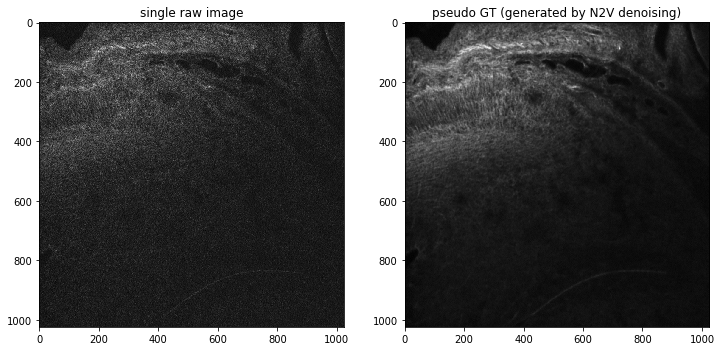

In [8]:
# In bootstrap mode, we estimate pseudo GT by using N2V denoised images.
signal = np.array(resultImgs)   
# Let's look the raw data and our pseudo ground truth signal
print(signal.shape)
plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 2)
plt.title(label='pseudo GT (generated by N2V denoising)')
plt.imshow(signal[0],cmap='gray')
plt.subplot(1, 2, 1)
plt.title(label='single raw image')
plt.imshow(observation[0],cmap='gray')
plt.show()

### Creating the Histogram Noise Model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a histogram based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [9]:
# We set the range of values we want to cover with our model.
# The pixel intensities in the images you want to denoise have to lie within this range.
# The dataset is clipped to values between 0 and 255.
minVal, maxVal = 305, 2905
bins = 260

# We are creating the histogram.
# This can take a minute.
histogram = pn2v.histNoiseModel.createHistogram(bins, minVal, maxVal, observation, signal)

# Saving histogram to disc.
np.save(path+nameHistNoiseModel+'.npy', histogram)
histogramFD=histogram[0]

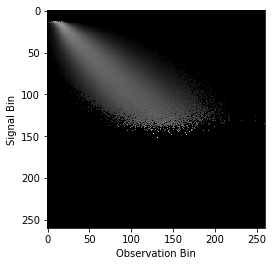

In [10]:
# Let's look at the histogram-based noise model
plt.xlabel('Observation Bin')
plt.ylabel('Signal Bin')
plt.imshow(histogramFD**0.25, cmap='gray')
plt.show()

### Creating the GMM noise model
Using the raw pixels $x_i$, and our averaged GT $s_i$, we are now learning a GMM based noise model. It describes the distribution $p(x_i|s_i)$ for each $s_i$. 

In [11]:
min_signal=np.percentile(signal, 0.5)
max_signal=np.percentile(signal, 99.5)
print("Minimum Signal Intensity is", min_signal)
print("Maximum Signal Intensity is", max_signal)

Minimum Signal Intensity is 485.4921875
Maximum Signal Intensity is 1139.133056640625


Iterating the noise model training for `n_epoch=4000`, `batchSize=25000` and `min_sigma` = 200 works the best for `Mouse actin` dataset. 

In [12]:
gaussianMixtureNoiseModel = pn2v.gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(min_signal, max_signal, path=path, weight = None, n_gaussian = n_gaussian, n_coeff = n_coeff, min_sigma = 200)
gaussianMixtureNoiseModel.train(signal, observation, batchSize = 25000, n_epochs = 4000, learning_rate = 0.1, name = nameGMMNoiseModel, lowerClip = 0.5, upperClip = 99.5)

0 11.249485969543457
100 5.690179824829102
200 5.680569648742676
300 5.682238578796387
400 5.664711952209473
500 5.664500713348389
600 5.672530651092529
700 5.662834644317627
800 5.669534683227539
900 5.668015003204346
1000 5.668093681335449
1100 5.675447463989258
1200 5.667862892150879
1300 5.663486003875732
1400 5.6668009757995605
1500 5.660061836242676
1600 5.665857315063477
1700 5.656425952911377
1800 5.657658576965332
1900 5.656661033630371
2000 5.674369812011719
2100 5.6618475914001465
2200 5.655786037445068
2300 5.658763408660889
2400 5.664673805236816
2500 5.6647725105285645
2600 5.652746677398682
2700 5.663424015045166
2800 5.664234161376953
2900 5.655473709106445
3000 5.661422252655029
3100 5.662781238555908
3200 5.666058540344238
3300 5.66748046875
3400 5.661740303039551
3500 5.663011074066162
3600 5.659372806549072
3700 5.656928062438965
3800 5.662662982940674
3900 5.671202182769775


### Visualizing the Histogram-based and GMM-based noise models

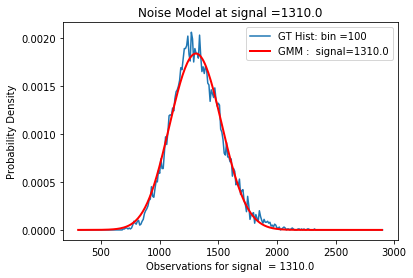

In [13]:
n_bin = 260
index= 100
min_signal=minVal
max_signal=maxVal
binclip=300
histBinSize=(max_signal-min_signal)/n_bin

querySignal_numpy= (index/float(n_bin)*(max_signal-min_signal)+min_signal)
querySignal_numpy+=histBinSize/2
querySignal_torch = torch.from_numpy(np.array(querySignal_numpy)).float().to(device)

idx = torch.from_numpy(np.arange(min_signal, max_signal, histBinSize)).float().to(device)
p=gaussianMixtureNoiseModel.likelihood(idx, querySignal_torch)
pNumpy=p.cpu().detach().numpy()

xvals=np.arange(n_bin)/float(n_bin)*(max_signal-min_signal)+min_signal
xvals+=histBinSize/2 


plt.plot(xvals[:binclip], histogramFD[index,:binclip]/histBinSize, label='GT Hist: bin ='+str(index))
plt.plot(np.arange(min_signal, max_signal,histBinSize)[:binclip], pNumpy[:binclip], label='GMM : '+' signal='+str(np.round(querySignal_numpy,2)),color='red',linewidth=2)
plt.xlabel('Observations for signal  = ' + str(querySignal_numpy))
plt.ylabel('Probability Density')
plt.title("Noise Model at signal =" + str(querySignal_numpy))
plt.legend()